In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
0# !rm -rf /content/drive/MyDrive/DATA/frames

In [ ]:
!find ./drive/MyDrive/data/frames/all/* -maxdepth 0 -type d | wc -l

find: ‘./drive/MyDrive/DATA/frames/all/*’: No such file or directory
0


In [ ]:
import cv2
import os
import dlib
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import json
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [ ]:
# set the number of frames to extract per second
n_frames = 1

root = './drive/MyDrive/dataset/'
train_dir_path = './drive/MyDrive/dataset/train_sample_videos/'
test_dir_path = './drive/MyDrive/dataset/test_videos/'

frame_path = './drive/MyDrive/dataset/frames/'
test_frames_path =  './drive/MyDrive/dataset/frames/all/'
train_frames_path =  './drive/MyDrive/dataset/frames/all/'
val_frames_path =  './drive/MyDrive/dataset/frames/all/'

shape_predictor_path = './drive/MyDrive/dataset/'

max_videos = -1

loadFromCSV = False
csv_path = root+'full_data.csv'


In [ ]:
def load_metadata():
    # read metadata.json

    # Open the JSON file
    with open(root+'metadata.json') as f:
        # Load the JSON data from the file
        metadata = json.load(f)

    file_info = []

    for video, value in metadata.items():
        file_info.append([train_dir_path + video, '0' if value['label'] == "REAL" else '1'])


    # get train records
    with open(root+'sample_submission.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        # skip first row
        next(reader)

        for row in reader:
            file_info.append([test_dir_path + row[0], row[1]])


    full_data = pd.DataFrame(file_info, columns = ['file', 'label'])
    print(full_data.shape[0], "videos found")

    # check duplicates
    try:
        duplicates = pd.concat(g for _, g in full_data.groupby("file") if len(g) > 1)
        print(duplicates.shape[0], "duplicate videos found")
    except ValueError:
        print("No duplicate videos found")

    # print distribution
    dist = full_data.groupby('label')['label'].count()
    print("Real : ", dist.loc['0'])
    print("Fake : ", dist.loc['1'], "\n")
    return full_data

In [ ]:
# Load the face detection model
detector = dlib.get_frontal_face_detector()

# Load the facial landmark detection model
predictor = dlib.shape_predictor(shape_predictor_path + 'shape_predictor_68_face_landmarks.dat')

def get_nose_and_mouth(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = detector(gray)

    landmarks = None

    for face in faces:
        landmarks = predictor(image, face)

    if not landmarks:
        # print("No face found.")
        return None

    mouth_x1 = landmarks.part(48).x
    mouth_y1 = landmarks.part(52).y
    mouth_x2 = landmarks.part(54).x
    mouth_y2 = landmarks.part(57).y

    nose_x1 = landmarks.part(31).x
    nose_y1 = landmarks.part(27).y
    nose_x2 = landmarks.part(35).x
    nose_y2 = landmarks.part(33).y

    mask = np.zeros_like(image)
    cv2.rectangle(mask, (mouth_x1, mouth_y1), (mouth_x2, mouth_y2), (255, 255, 255), -1)
    cv2.rectangle(mask, (nose_x1, nose_y1), (nose_x2, nose_y2), (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(image, mask)

    w = abs(max(mouth_x2, nose_x2) - min(mouth_x1, nose_x1))
    h = abs(max(mouth_y2, nose_y2) - min(mouth_y1, nose_y1))

    x1 = int(min(mouth_x1, nose_x1) - w*0.1)
    y1 = int(min(mouth_y1, nose_y1) - h*0.1)
    x2 = int(max(mouth_x2, nose_x2) + w*0.1)
    y2 = int(max(mouth_y2, nose_y2) + h*0.1)

    masked_img = masked_img[y1:y2, x1:x2]

    return masked_img

In [ ]:
def add_list_df(df, data):
    img_data = pd.DataFrame(data, columns=['path', 'label'])
    df1 = pd.concat([df, img_data], ignore_index=True)
    return df1

def convert_video_to_frames(df, dest_path):
    i = 0

    image_data = pd.DataFrame([], columns=['path', 'label'])
    os.makedirs(dest_path, exist_ok=True)


    # loop through each video file in the directory
    for index, row in df.iterrows():
        i += 1
        filename = row['file']
        label = row['label']


        if max_videos > 0 and i > max_videos:
            return image_data;

        if filename.endswith('.mp4'): # check if the file is an mp4 video
            # open the video file
            video = cv2.VideoCapture(filename)
            data = []

            file_key = filename.rsplit('/',1)[1][:-4]

            fdir = os.path.join(dest_path, file_key)

            if os.path.isdir(fdir):
                data = []
                img_count = 0

                for img_file in os.listdir(fdir):
                    img_count += 1
                    if img_file.endswith("jpg"):
                        data.append([os.path.join(fdir, img_file), label])

                image_data = add_list_df(image_data, data)

                if img_count != 0:
                    print(i, '.', img_count, "Frames found. Skipping", file_key, '\n')
                    continue

            os.makedirs(dest_path+file_key, exist_ok=True)


            # get the frames per second (fps) of the video
            fps = video.get(cv2.CAP_PROP_FPS)

            # calculate the interval between frames to extract
            frame_interval = int(fps / n_frames)

            # set the frame counter and file counter
            count = 0
            file_count = 1

            # loop through the video frames and extract the desired number of frames per second
            print(i, ". starting... ", file_key)

            while True:
                ret, frame = video.read()
                if not ret:
                    break
                if count % frame_interval == 0:
                    # save the extracted frame as an image file
                    img_filename = f"{file_key}_{file_count:03d}.jpg" # use a unique file name
                    img_path = os.path.join(dest_path, file_key, img_filename)

                    # extract nose and mouth
                    frame = get_nose_and_mouth(frame)
                    if frame is None:
                        continue

                    cv2.imwrite(img_path, frame)
                    data.append([img_path, label])


                    file_count += 1
                count += 1

            # add to image_data
            image_data = add_list_df(image_data, data)

            print("---- Frames saved. ", "\n")
            # release the video object
            video.release()

    return image_data

In [ ]:
def startConvert():
    metadata = load_metadata()

    train_metadata, test_metadata = train_test_split(metadata, test_size=0.2,
                                                     stratify=metadata.loc[:, 'label'])
    train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.2,
                                                    stratify=train_metadata.loc[:, 'label'])

    # convert and save to csv
    print("--- Train set conversion \n")
    train_data = convert_video_to_frames(train_metadata, train_frames_path )
    train_data.to_csv(frame_path+'train.csv', sep='\t', index=False)

    print("--- Test set conversion \n")
    test_data = convert_video_to_frames(test_metadata, test_frames_path)
    test_data.to_csv(frame_path+'test.csv', sep='\t', index=False)

    print("--- Validation set conversion \n")
    val_data = convert_video_to_frames(val_metadata, val_frames_path)
    val_data.to_csv(frame_path+'val.csv', sep='\t', index=False)


    print("Written to csv \n")

def getData():

    dtypes = dtypes = {'path': str, 'label': str}

    train_set = pd.read_csv(frame_path+'train.csv' , sep='\t', dtype=dtypes)
    test_set = pd.read_csv(frame_path+'test.csv', sep='\t', dtype=dtypes)
    val_set = pd.read_csv(frame_path+'val.csv', sep='\t', dtype=dtypes)

    return train_set, val_set, test_set

if not loadFromCSV:
    startConvert()

800 videos found
No duplicate videos found
Real :  477
Fake :  323 

--- Train set conversion 

1 . starting...  bseamdrpbj
---- Frames saved.  

2 . starting...  nikynwcvuh
---- Frames saved.  

3 . starting...  ecwaxgutkc
---- Frames saved.  

4 . starting...  dnmowthjcj
---- Frames saved.  

5 . starting...  cyclgfjdrv
---- Frames saved.  

6 . starting...  itfsvvmslp
---- Frames saved.  

7 . starting...  clihsshdkq
---- Frames saved.  

8 . starting...  axntxmycwd
---- Frames saved.  

9 . starting...  bbhpvrmbse
---- Frames saved.  

10 . starting...  aomqqjipcp
---- Frames saved.  

11 . starting...  uoccaiathd
---- Frames saved.  

12 . starting...  dnhvalzvrt
---- Frames saved.  

13 . starting...  dkwjwbwgey
---- Frames saved.  

14 . starting...  cizlkenljw
---- Frames saved.  

15 . starting...  bwhlgysghg
---- Frames saved.  

16 . starting...  qclpbcbgeq
---- Frames saved.  

17 . starting...  eisofhptvk
---- Frames saved.  

18 . starting...  uvrzaczrbx
---- Frames saved

In [ ]:
train_set, validation_set, test_set = getData()

print("Train set : ", train_set.shape[0])
print("Validation set : ", validation_set.shape[0])
print("Test set : ", test_set.shape[0])

Train set :  4835
Validation set :  1265
Test set :  1532


In [ ]:
# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

input_shape = (247, 163, 3)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

Found 4835 validated image filenames belonging to 2 classes.
Found 1265 validated image filenames belonging to 2 classes.
Found 1532 validated image filenames belonging to 2 classes.


In [ ]:
def get_CNN_model(input_shape):
    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def test_model(model):
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )

    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(test_generator, verbose=2)
    print('Test accuracy:', test_acc)

    # Generate predictions for the test set
    y_pred = model.predict(test_generator)
    y_pred = np.round(y_pred).flatten()

    # Print the classification report and confusion matrix
    # print(classification_report(test_generator.classes, y_pred))
    # print(confusion_matrix(test_generator.classes, y_pred))

   # Plot the training and testing accuracy
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='testing accuracy')
    plt.legend()
    plt.show()
    # Plot the training and testing loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='testing loss')
    plt.legend()
    plt.show()

Epoch 1/10
151/151 [==============================] - 1074s 7s/step - loss: 0.5852 - accuracy: 0.6760 - val_loss: 0.4922 - val_accuracy: 0.7564
Epoch 2/10
151/151 [==============================] - 331s 2s/step - loss: 0.4235 - accuracy: 0.7966 - val_loss: 0.4325 - val_accuracy: 0.7901
Epoch 3/10
151/151 [==============================] - 304s 2s/step - loss: 0.3904 - accuracy: 0.8132 - val_loss: 0.4078 - val_accuracy: 0.7973
Epoch 4/10
151/151 [==============================] - 309s 2s/step - loss: 0.3192 - accuracy: 0.8557 - val_loss: 0.3032 - val_accuracy: 0.8638
Epoch 5/10
151/151 [==============================] - 325s 2s/step - loss: 0.3060 - accuracy: 0.8613 - val_loss: 0.3069 - val_accuracy: 0.8606
Epoch 6/10
151/151 [==============================] - 313s 2s/step - loss: 0.2216 - accuracy: 0.9053 - val_loss: 0.2455 - val_accuracy: 0.8950
Epoch 7/10
151/151 [==============================] - 310s 2s/step - loss: 0.1773 - accuracy: 0.9294 - val_loss: 0.2936 - val_accuracy: 0.888

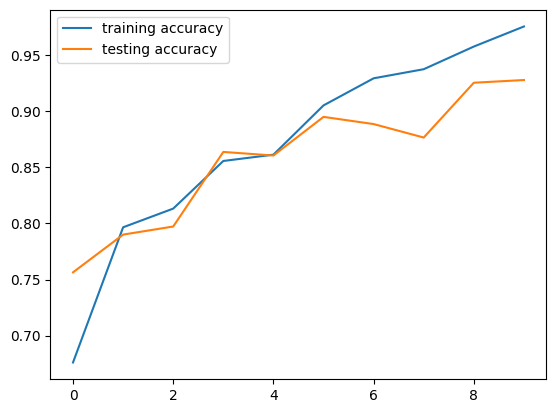

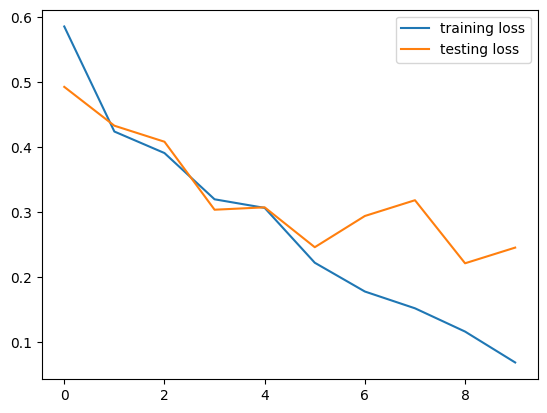

In [ ]:
model = get_CNN_model(input_shape)
test_model(model)

9.10-------11.50


In [ ]:
model.save(root+"cnn_model.h5")

In [ ]:
def get_MobileNetV2_model(input_shape):
    # Load the pre-trained MobileNetV2 model
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in mobilenetv2.layers:
        layer.trainable = False

    # Add your own layers on top of the pre-trained model
    x = GlobalAveragePooling2D()(mobilenetv2.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=mobilenetv2.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
151/151 [==============================] - 155s 1s/step - loss: 0.5147 - accuracy: 0.7491 - val_loss: 0.4464 - val_accuracy: 0.7796
Epoch 2/10
151/151 [==============================] - 145s 959ms/step - loss: 0.3997 - accuracy: 0.8157 - val_loss: 0.6006 - val_accuracy: 0.7188
Epoch 3/10
151/151 [==============================] - 140s 930ms/step - loss: 0.3379 - accuracy: 0.8459 - val_loss: 0.4804 - val_accuracy: 0.7676
Epoch 4/10
151/151 [==============================] - 152s 1s/step - loss: 0.2876 - accuracy: 0.8759 - val_loss: 0.4082 - val_accuracy: 0.8229
Epoch 5/10
151/151 [==============================] - 150s 994ms/step - loss: 0.2771 - accuracy: 0.8811 - val_loss: 0.3197 - val_accuracy: 0.8654
Epoch 6/10
151/151 [==============================] - 150s 994ms/step - loss: 0.2326 - accuracy: 0.9026 - val_loss: 0.3007 - val_accuracy: 0.8766
Epoch 7/10
151/151 [==============================] - 138s 914ms/st

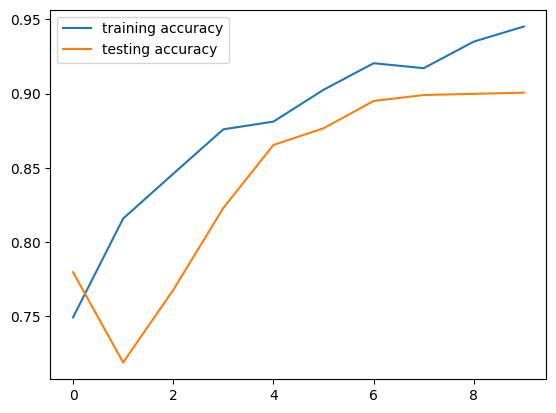

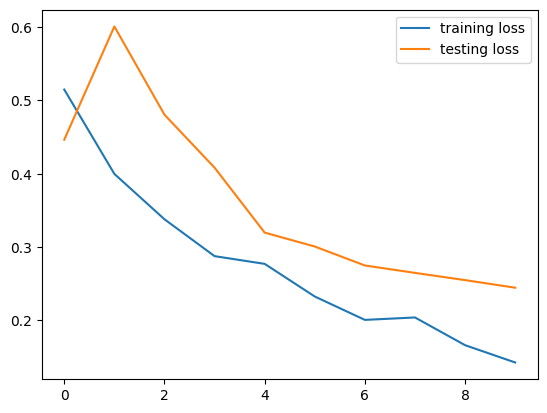

In [ ]:
model = get_MobileNetV2_model(input_shape)
test_model(model)

12.00---------1.00

In [ ]:
model.save(root+"mobile_net_model.h5")

In [ ]:
def get_DenseNet121_model(input_shape):
    # Load the pre-trained DenseNet121 model
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in densenet.layers:
        layer.trainable = False

    # Add your own layers on top of the pre-trained model
    x = GlobalAveragePooling2D()(densenet.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=densenet.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
151/151 [==============================] - 537s 4s/step - loss: 0.5810 - accuracy: 0.7148 - val_loss: 0.4867 - val_accuracy: 0.7845
Epoch 2/10
151/151 [==============================] - 562s 4s/step - loss: 0.4657 - accuracy: 0.7851 - val_loss: 0.4526 - val_accuracy: 0.7917
Epoch 3/10
151/151 [==============================] - 568s 4s/step - loss: 0.3993 - accuracy: 0.8218 - val_loss: 0.4488 - val_accuracy: 0.7829
Epoch 4/10
151/151 [==============================] - 540s 4s/step - loss: 0.3787 - accuracy: 0.8347 - val_loss: 0.4292 - val_accuracy: 0.8109
Epoch 5/10
151/151 [==============================] - 560s 4s/step - loss: 0.3531 - accuracy: 0.8476 - val_loss: 0.4073 - val_accuracy: 0.8005
Epoch 6/10
151/151 [==============================] - 524s 3s/step - loss: 0.3022 - accuracy: 0.8732 - val_loss: 0.3527 - val_accuracy: 0.8598
Epoch 8/10
151/151 [==============================] - 562s 4s/step - loss: 0.

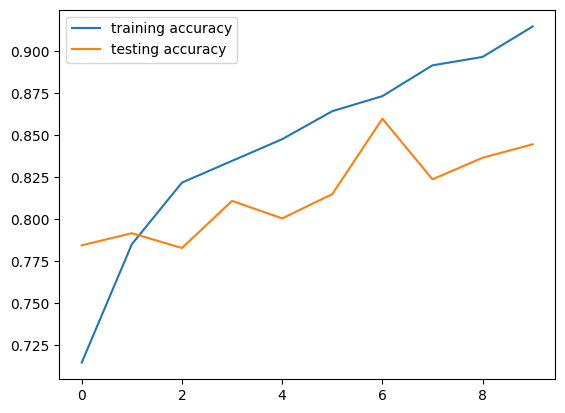

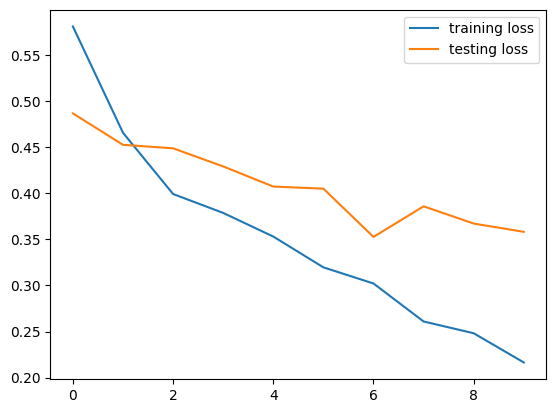

In [ ]:
model = get_DenseNet121_model(input_shape)
test_model(model)

In [ ]:
model.save(root+"densenet_model.h5")

Found 4835 validated image filenames belonging to 2 classes.
Found 1265 validated image filenames belonging to 2 classes.
Found 1532 validated image filenames belonging to 2 classes.
Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 247, 163, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            8088129     ['input_3[0][0]']                
                                                                                                  
 get_MobileNetV2_model (Functio  (None, 1)           3570753     ['input_3[0][0]']                
 nal)  

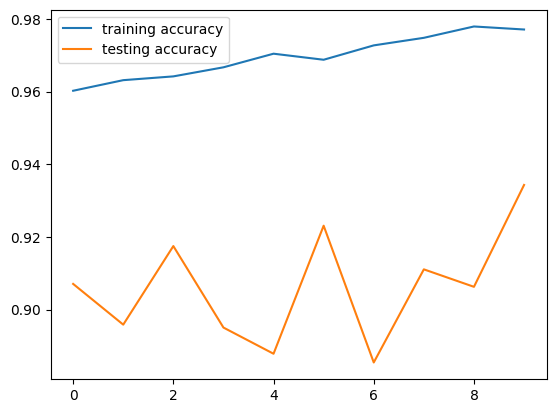

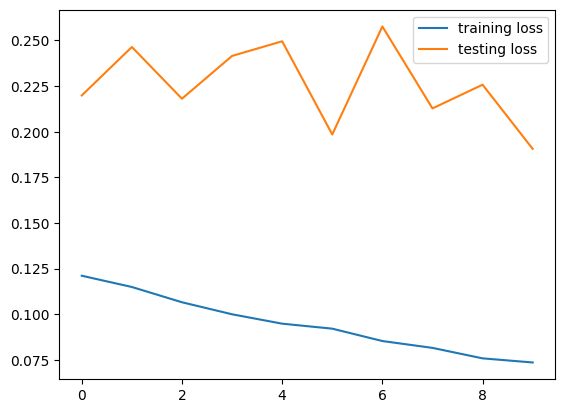

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

input_shape = (247, 163, 3)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)


model_1 = load_model('/content/drive/MyDrive/DATA/cnn_model.h5')
x = Flatten()(model_1.layers[-2].output)
output = Dense(1, activation='sigmoid')(x)
get_CNN_model = Model(inputs=model_1.input, outputs=output)

model_2 = load_model('/content/drive/MyDrive/DATA/mobile_net_model.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='get_MobileNetV2_model')
model_3 = load_model('/content/drive/MyDrive/DATA/densenet_model.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='get_DenseNet121_model')
models = [model_1,model_2, model_3]


model_input = Input(shape=(247,163, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')


ensemble_model.compile(optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model.summary()


history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1
)
test_model(ensemble_model)

In [ ]:
model.save(root+"ensemble_model.h5")